In [0]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
# 1. Load cleaned sales data
sales_df = spark.read.format("delta").load("/mnt/cleaned_data/sales_df")

In [0]:
sales_df.printSchema()


root
 |-- Product_ID: integer (nullable = true)
 |-- Sale_Date: date (nullable = true)
 |-- Sales_Rep: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Sales_Amount: double (nullable = true)
 |-- Quantity_Sold: integer (nullable = true)
 |-- Product_Category: string (nullable = true)
 |-- Unit_Cost: double (nullable = true)
 |-- Unit_Price: double (nullable = true)
 |-- Customer_Type: string (nullable = true)
 |-- Discount: double (nullable = true)
 |-- Payment_Method: string (nullable = true)
 |-- Sales_Channel: string (nullable = true)
 |-- Region_and_Sales_Rep: string (nullable = true)
 |-- Customer_ID: long (nullable = true)



In [0]:
from pyspark.sql.functions import to_date, col, unix_timestamp
from pyspark.sql.functions import sum as spark_sum
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from datetime import datetime, timedelta

# Parse dates
sales_df = sales_df.withColumn("Sale_Date", to_date(col("Sale_Date")))

In [0]:
daily_sales = sales_df.groupBy("Sale_Date").agg(
    spark_sum("Sales_Amount").alias("Daily_Sales")
)

In [0]:
from pyspark.sql.functions import lit

In [0]:
# Use earliest date as reference
min_date = daily_sales.agg({"Sale_Date": "min"}).collect()[0][0]

# Add Day_Index
daily_sales = daily_sales.withColumn(
    "Day_Index", (unix_timestamp(col("Sale_Date")) - unix_timestamp(lit(min_date))) / 86400
)
daily_sales = daily_sales.withColumn("Day_Index", col("Day_Index").cast("double"))  

In [0]:
daily_sales.select("Day_Index", "Daily_Sales").dropna().printSchema()
daily_sales.show(5)

root
 |-- Day_Index: double (nullable = true)
 |-- Daily_Sales: double (nullable = true)

+----------+------------------+---------+
| Sale_Date|       Daily_Sales|Day_Index|
+----------+------------------+---------+
|2023-06-22|          22602.94|    172.0|
|2023-07-15|           7405.74|    195.0|
|2023-05-22| 7996.389999999999|    141.0|
|2023-09-14|21394.420000000002|    256.0|
|2023-11-08|10539.480000000001|    311.0|
+----------+------------------+---------+
only showing top 5 rows



In [0]:
assembler = VectorAssembler(inputCols=["Day_Index"], outputCol="features")
assembled = assembler.transform(daily_sales).select("features", "Daily_Sales").dropna()

In [0]:
lr = LinearRegression(featuresCol="features", labelCol="Daily_Sales")
model = lr.fit(assembled)

In [0]:
future_days = [(datetime.today() + timedelta(days=i)) for i in range(1, 8)]
min_ts = datetime.combine(min_date, datetime.min.time()).timestamp()

# Create Day_Index for future
future_df = spark.createDataFrame(
    [(float((d.timestamp() - min_ts)/86400),) for d in future_days], ["Day_Index"]
)

future_df = future_df.withColumn("Day_Index", col("Day_Index").cast("double"))

# Assemble & Predict
future_df = assembler.transform(future_df)
predictions = model.transform(future_df)
predictions.show()

+-----------------+-------------------+------------------+
|        Day_Index|           features|        prediction|
+-----------------+-------------------+------------------+
|940.6716135808798|[940.6716135808798]|15919.109769979284|
|941.6716135810426|[941.6716135810426]| 15920.63342724081|
|942.6716135810647|[942.6716135810647]| 15922.15708450212|
|943.6716135810867|[943.6716135810867]| 15923.68074176343|
|944.6716135811006|[944.6716135811006]| 15925.20439902473|
|945.6716135811226|[945.6716135811226]| 15926.72805628604|
|946.6716135811337|[946.6716135811337]|15928.251713547334|
+-----------------+-------------------+------------------+



In [0]:
import matplotlib.pyplot as plt

Day_Index,prediction,Date
940.6716135808798,15919.109769979284,2025-07-29T16:07:10.699783Z
941.6716135810426,15920.63342724081,2025-07-30T16:07:10.699801Z
942.6716135810647,15922.15708450212,2025-07-31T16:07:10.699805Z
943.6716135810867,15923.68074176343,2025-08-01T16:07:10.699809Z
944.6716135811006,15925.20439902473,2025-08-02T16:07:10.699813Z
945.6716135811226,15926.72805628604,2025-08-03T16:07:10.699817Z
946.6716135811337,15928.251713547334,2025-08-04T16:07:10.699821Z


Databricks visualization. Run in Databricks to view.

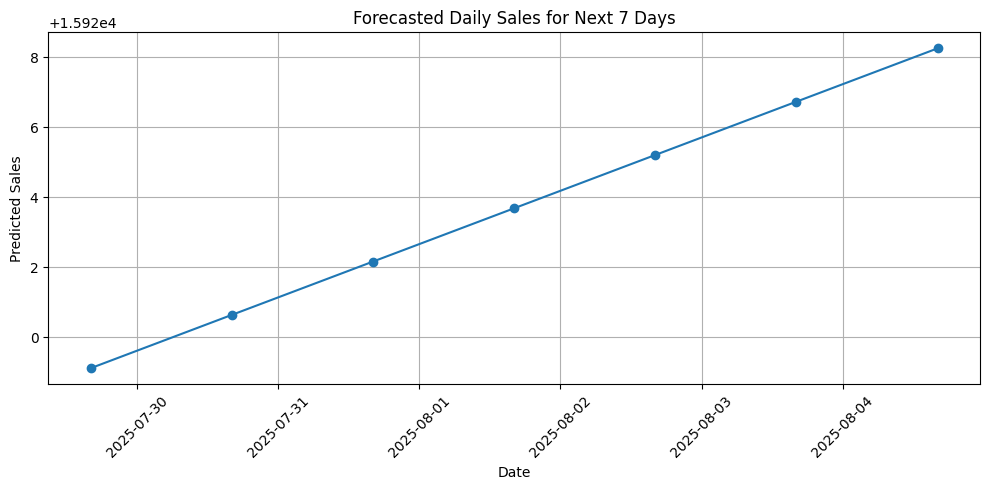

In [0]:

# Convert Spark predictions to Pandas DataFrame
predicted_data = predictions.select("Day_Index", "prediction").toPandas()

# Add future dates if needed
from datetime import datetime, timedelta
future_dates = [(datetime.today() + timedelta(days=i)) for i in range(1, 8)]
predicted_data["Date"] = future_dates
display(predicted_data)
# Plot
plt.figure(figsize=(10, 5))
plt.plot(predicted_data["Date"], predicted_data["prediction"], marker='o', linestyle='-')
plt.title("Forecasted Daily Sales for Next 7 Days")
plt.xlabel("Date")
plt.ylabel("Predicted Sales")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [0]:
jdbc_url = "jdbc:sqlserver://geeta.database.windows.net:1433;databaseName=db_dev"

connection_properties = {
    "user": "geeta@geeta",  
    "password": "Chaitu@13",  
    "driver": "com.microsoft.sqlserver.jdbc.SQLServerDriver"
}
spark.createDataFrame(predicted_data).write.jdbc(jdbc_url, "Sales_Forecast", "overwrite", connection_properties)